In [1]:
# import preprocess as prep
import SLR_model
import numpy as np
import tensorflow as tf
from tensorflow import keras
import time
import os
import json
import importlib
from matplotlib import pyplot as plt
import preprocess
# from preprocess import person

# model will output multiple(5) results/sec, how are we gonna handle it?

In [2]:
 # reload model file
importlib.reload(SLR_model)
importlib.reload(preprocess)

<module 'preprocess' from 'C:\\Users\\shd\\Documents\\capstone\\BomNae-SLR\\preprocess.py'>

In [3]:
# Configurations
load_size = 256 # number of data to be loaded at once
epochs = 20
batch_size = 16
save_dir = "saves"
load_dir = "saves"
# load_path = "C:/Users/jerry/Desktop/hly/2024-2/cap/BN_SLR/BomNae-SLR/checkpoints.keras"


In [4]:
model = SLR_model.get_model()

In [21]:
# hand input shape: (batch, time, h, w, channels)
# pose input shape: (batch, time, channel, features)

In [24]:
# # 세이브된 모델 로드
# load_path = os.join(load_dir, "check_00-00-00.keras")
# model = SLR_model.load_model(load_path)

In [1]:
# # 안될때 (강제중지 + 초기화)
# tf.keras.backend.clear_session()

In [ ]:
# l_raws=[]
# r_raws=[]
# p_raws=[]
# y_raws=[]


# save_suffix = time.strftime("_%d-%H-%M", time.localtime(time.time()))
# check_path = os.path.join(save_dir, "check"+save_suffix)
# hist_path = os.path.join(save_dir, "hist"+save_suffix+".json")

# model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
#     filepath=f'{check_path}.keras',
#     monitor='binary_accuracy',
#     mode='max',
#     save_freq='epoch',
#     save_best_only=True)



# l_raw, r_raw, p_raw, y_raw = preprocess.load_data(f"1/1")

# l_raws.append(l_raw)
# r_raws.append(r_raw)
# p_raws.append(p_raw)
# y_raws.append(y_raw)


# l_train, each = SLR_model.serialize(l_raws)
# r_train, each = SLR_model.serialize(r_raws)
# p_train, each = SLR_model.serialize(p_raws, stride=2)
# y_train = np.repeat(y_raws, each)
# y_train = SLR_model.num_arr2bin(y_train, 12)
# x_train = (l_train, r_train, p_train)

# # dataset = SLR_model.convert_to_dataset(x_train, y_train, batch_size)
# hist = model.fit(x_train, y_train, batch_size = 2, epochs=epochs, callbacks=[model_checkpoint_callback])

# with open(hist_path, 'w') as file:
#     json.dump(hist.history, file)


In [5]:
 # reload model file
importlib.reload(SLR_model)
importlib.reload(preprocess)
end_file=preprocess.getoutputdir()

save_suffix = time.strftime("_%d-%H-%M", time.localtime(time.time()))
check_path = os.path.join(save_dir, "check"+save_suffix)
hist_path = os.path.join(save_dir, "hist"+save_suffix+".json")

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=f'{check_path}.keras',
    monitor='binary_accuracy',
    mode='max',
    save_freq='epoch',
    save_best_only=True)


for i in range(1,17):
    load_size_j=load_size
    l_raws=[]
    r_raws=[]
    p_raws=[]
    y_raws=[]
    loss_weights_raws=[]
    start_word=" "
    
    for j in os.listdir(os.path.join(preprocess.getoutputdir(),str(i))):
        l_raw, r_raw, p_raw, y_raw, loss_weights_raw = preprocess.load_data(f"{i}/{j}")
        l_raws.append(l_raw)
        r_raws.append(r_raw)
        p_raws.append(p_raw)
        y_raws.append(y_raw)
        loss_weights_raws.append(loss_weights_raw)
        if len(l_raws)==0:
            start_word = j
        else:
            end_word = j
        if len(l_raws)>=load_size:
            print(f"person:{i} : {start_word} ~ {end_word}")
            l_train, each = SLR_model.serialize(l_raws)
            r_train, each = SLR_model.serialize(r_raws)
            p_train, each, sample_weights = SLR_model.serialize(p_raws, stride=2, loss_weights_list=loss_weights_raws)
            x_train = (l_train, r_train, p_train)
            
            y_train = np.repeat(y_raws, each)
            y_train = SLR_model.num_arr2bin(y_train, 12)

            dataset = SLR_model.convert_to_dataset(x_train, y_train, batch_size, sample_weights)
            hist = model.fit(dataset, epochs=epochs, callbacks=[model_checkpoint_callback])
            
            with open(hist_path, 'w') as file:
                json.dump(hist.history, file)
            l_raws.clear()
            r_raws.clear()
            p_raws.clear()
            y_raws.clear()
            loss_weights_raws.clear()
    if len(l_raws)>0:
        l_train, each = SLR_model.serialize(l_raws)
        r_train, each = SLR_model.serialize(r_raws)
        p_train, each, sample_weights = SLR_model.serialize(p_raws, stride=2, loss_weights_list=loss_weights_raws)
        x_train = (l_train, r_train, p_train)
        
        y_train = np.repeat(y_raws, each)
        y_train = SLR_model.num_arr2bin(y_train, 12)

        dataset = SLR_model.convert_to_dataset(x_train, y_train, batch_size, sample_weights)
        hist = model.fit(dataset, epochs=epochs, callbacks=[model_checkpoint_callback])
        
        with open(hist_path, 'w') as file:
            json.dump(hist.history, file)

    

weight:138/l_raw:138
weight:133/l_raw:133
weight:94/l_raw:94
weight:118/l_raw:118
weight:114/l_raw:114
weight:121/l_raw:121
weight:137/l_raw:137
weight:118/l_raw:118
weight:131/l_raw:131
weight:135/l_raw:135
weight:112/l_raw:112
weight:119/l_raw:119
weight:103/l_raw:103
weight:149/l_raw:149
weight:112/l_raw:112
weight:144/l_raw:144
weight:105/l_raw:105
weight:111/l_raw:111
weight:110/l_raw:110
weight:117/l_raw:117
weight:107/l_raw:107
weight:129/l_raw:129
weight:132/l_raw:132
weight:137/l_raw:137
weight:118/l_raw:118
weight:141/l_raw:141
weight:138/l_raw:138
weight:127/l_raw:127
weight:116/l_raw:116
weight:156/l_raw:156
weight:124/l_raw:124
weight:134/l_raw:134
weight:165/l_raw:165
weight:139/l_raw:139
weight:139/l_raw:139
weight:134/l_raw:134
weight:132/l_raw:132
weight:124/l_raw:124
weight:148/l_raw:148
weight:109/l_raw:109
weight:141/l_raw:141
weight:139/l_raw:139
weight:101/l_raw:101
weight:124/l_raw:124
weight:123/l_raw:123
weight:120/l_raw:120
weight:157/l_raw:157
weight:128/l_ra

TypeError: serialize() got an unexpected keyword argument 'loss_weights'

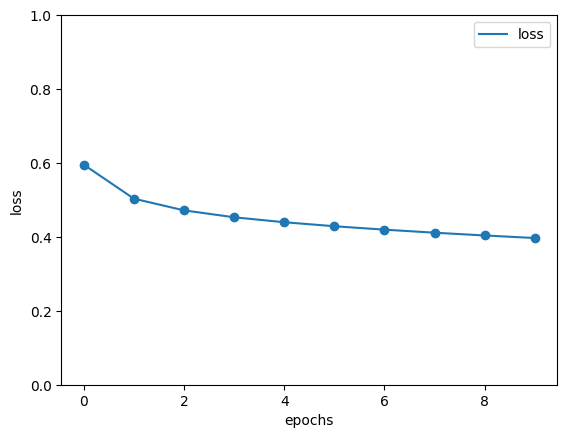

In [37]:
plt.plot(range(len(hist.history['loss'])), hist.history['loss'])
plt.scatter(range(len(hist.history['loss'])), hist.history['loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["loss"])
plt.ylim((0,1))
plt.show()

In [14]:
model.metrics_names

['loss', 'compile_metrics']